<h1>Control in State Space</h1>
<h2>System definition</h2>
<p>This notebook presents different aspects of design of controller in the state space<br>
The analysis will be performed first in the continuous time domain and then in the discrete time domain.<br>
Let us start defining a system in the state space</p>


In [1]:
% Set the Octave Engine to run the simulation
SetSimulationEnvironment;

A = [1 1; -2 -1]
B = [1; 1]
C = [1 0]
D = 0


A =

   1   1
  -2  -1

B =

   1
   1

C =

   1   0

D = 0


<h2>Continuous-time design</h2>
<p>As first step we need to check the controllability of the system<br>
To this purpose it is important that the rank of the matrix is equal to the order of the system</p>

In [2]:
Sc = [B A*B]
rank(Sc)

Sc =

   1   2
   1  -3

ans =  2


<p>Another key information is the evaluation of the eigenvalues in open loop</p>

In [20]:
eigs(A)

ans =

  -0.00000 + 1.00000i
  -0.00000 - 1.00000i



<p>To close the loop, we specify the pole position and calculate the gain of the feedback</p>

In [21]:
pt = [-2+1j*2 -2-1j*2];
K = place(A,B,pt)

K =

   3.80000   0.20000



<p>Simulation can be used to verify the system behavior <br>
First we simulate the free evolution of the system in open loop</p>

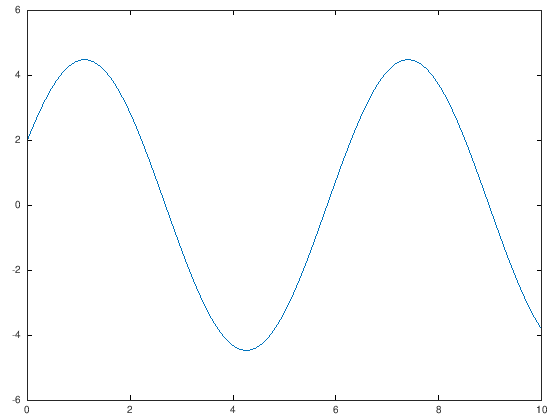

In [22]:
% Simulation Parameters
% Start time
tini = 0;
% End time
tfinal = 10;
% Time Step
dt = 0.01;
% Number of data flows in the schematic
nflows = 4;


xo = [2; 2];

% Instance of the simulation schematic
sc1 = Schema(tini,tfinal,dt,nflows);

% List of components
c1{1} = Constant(1,0);
c1{2} = StateSpace(1,2,A,B,C,D,xo);

sc1.AddListComponents(c1);

% Run the schematic and plot
out1 = sc1.Run([1,2]);
plot(out1(1,:),out1(3,:));

<p>Then we analyse the behavior in closed loop</p>

In [23]:
% Instance of the simulation schematic
sc2 = Schema(tini,tfinal,dt,nflows);

C2 = [1 0; 0 1];

% List of components
c2{1} = StateSpace(1,[2 3],A,B,C2,D,xo);
c2{2} = Gain([2 3],1,-K);

sc2.AddListComponents(c2);

% Run the schematic and plot
out2 = sc2.Run([2]);
plot(out2(1,:),out2(2,:));

<p>The previous simulation was performed on the autonomous system.<br>
Another aspect is the study of systems for which we want to set a specific reference<br>
First of all we need to rescale the gain of the reference to make the overall gain unity</p>

In [25]:
V = inv(C*inv(B*K-A)*B)

V =  4.0000


<p>Next simulation analyses the closed-loop behaviour given a step to reference<br>
We expect to find then a modified steady state</p>

In [27]:
% Number of data flows in the schematic
nflows2 = 6;

% Instance of the simulation schematic
sc3 = Schema(tini,tfinal,dt,nflows2);

% List of components
c3{1} = StepSource(1,0,1,0.1);
c3{2} = Gain(1,2,V);
c3{3} = Sum(2,3,4,1,1); 
c3{4} = StateSpace(4,[5 6],A,B,C2,D,xo);
c3{5} = Gain([5 6],3,-K);

sc3.AddListComponents(c3);

% Run the schematic and plot
out3 = sc3.Run([5]);
plot(out3(1,:),out3(2,:));

<p>Let us now consider a new system<br>
This system is unstable in open loop and not controllable</p>

In [10]:
An = [1 0; 0 -1]
Bn = [1; 0]
Cn = [1 0]
Dn = 0

An =

   1   0
   0  -1

Bn =

   1
   0

Cn =

   1   0

Dn = 0


<p>The rank is one and this means that is not fully controllable</p>

In [28]:
Sn = [Bn An*Bn]
rank(Sn)

Sn =

   1   1
   0   0

ans =  1


<p>From the eigenvalues we can verify that the system is actually unstable on open loop</p>

In [29]:
eigs(An)

ans =

  -1
   1



<p>The simulation confirms the open loop behavior as unstable system</p>

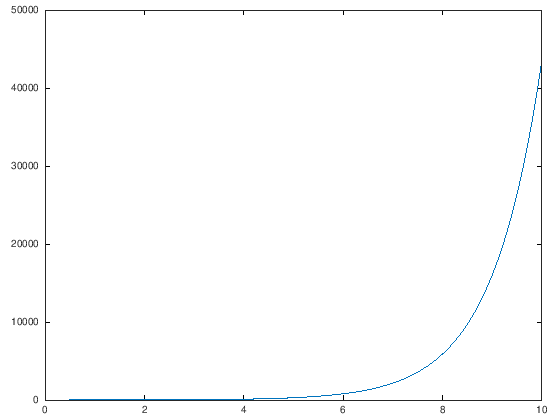

In [30]:
% Instance of the simulation schematic
sc4 = Schema(tini,tfinal,dt,nflows);

% List of components
c4{1} = Constant(1,0);
c4{2} = StateSpace(1,[2 3],An,Bn,Cn,Dn,xo);

sc4.AddListComponents(c4);

% Run the schematic and plot
out4 = sc4.Run([2]);
plot(out4(1,:),out4(2,:));

<p>Even if the system is unstable in open loop and not controllable, it is still possible to close the loop and make it stable<br>
The solutions is obtained moving the unstable eigenvalue by means of a feedback of one of the two state variables</p>

In [31]:
% Instance of the simulation schematic
sc5 = Schema(tini,tfinal,dt,nflows);

Ks = 4;

% List of components
c5{1} = StateSpace(1,2,An,Bn,Cn,Dn,xo);
c5{2} = Gain(2,1,-Ks);

sc5.AddListComponents(c5);

% Run the schematic and plot
out5 = sc5.Run([2]);
plot(out5(1,:),out5(2,:));

<h2>Role of pole positions in relation to effort of the input channel</h2>
<p>Another key point is to understand the consequences of selecting a specific position for the poles<br>
In effect, the more we increase the speed of the dynamics of the system, the more we may need a higher value for the input channel<br>
This is correct under the assumption of linearity, but, in reality, we need to remember that actuators have always a limit: as result the obtained input value may actually unfeasible in the real world</p>

csi =  0.70000
max =  10


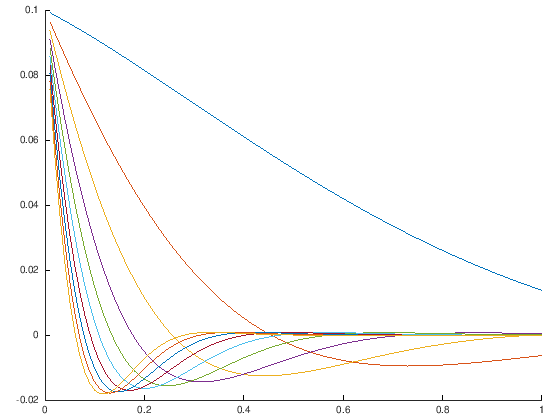

In [35]:
csi = 0.7
xini = [0.1; 0.1];
deltat = 0.01;
omr = 2;
max = 10
nstep = 100;
for i=1:max
    omo = i*omr;
    pdo = [-csi*omo+1j*omo*sqrt(1-csi*csi) -csi*omo-1j*omo*sqrt(1-csi*csi)];
    Ff = place(A,B,pdo);
    Acl = A-B*Ff;
    for q=1:nstep
        y(i,q)= C*expm(Acl*deltat*q)*xini;
        u(i,q)= -Ff*expm(Acl*deltat*q)*xini;
    end
end


hold on
for i=1:max
    plot((1:nstep)*deltat,y(i,:));
end
hold off    
        

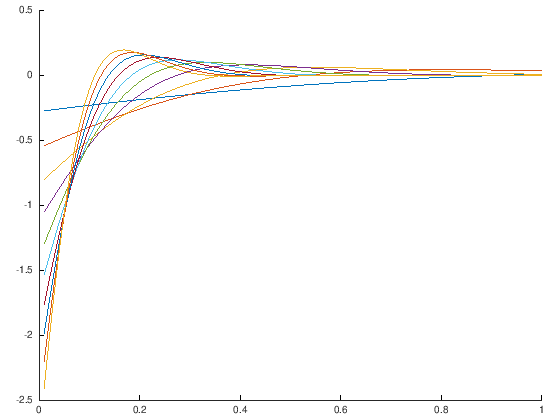

In [36]:
hold on
for i=1:max
    plot((1:nstep)*deltat,u(i,:));
end
hold off    



<h2>Discrete-time design</h2>
<p>Last but not least topic is the implementation as a digital controller<br>
The design can be performed completely in the discrete time by performing the transformation of the plant model<br>
Given that the controller is simply a proportional action, it become interesting also to understand the value of the original design in continuous time and to compare the two outcomes.<br>
Results show that applying the coefficients of the control calculated in continuous time directly in discrete time does not bring the same results. By performing the calculations fully in the discrete time domain, viceversa, we have the same results as in continuous time</p>

In [38]:
Ts = 0.1;

Ad = expm(A*Ts);
Bd = (Ad-eye(2))*inv(A)*B

pdd = exp(pt*Ts)

Fd = place(Ad,Bd,pdd)

Bd =

   0.109825
   0.084846

pdd =

   0.80241 + 0.16266i   0.80241 - 0.16266i

Fd =

   3.25925   0.32105



<p>Simulation results confirm the theoretical assumptions</p>

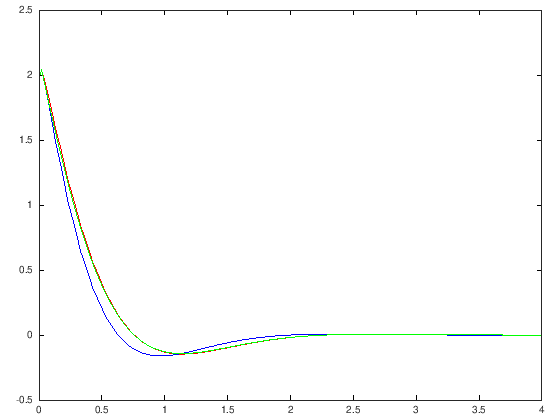

In [39]:
% Instance of the simulation schematic
nflowsd = 11;
tfinal = 4;
dt = 0.01;
sc6 = Schema(tini,tfinal,dt,nflowsd);

% List of components
c6{1} = StateSpace(1,[2 3],A,B,C2,D,xo);
c6{2} = Gain([2 3],4,-Fd);
c6{3} = ZOH(4,1,Ts);
c6{4} = StateSpace(5,[6 7],A,B,C2,D,xo);
c6{5} = Gain([6 7],8,-K);
c6{6} = ZOH(8,5,Ts);
c6{7} = StateSpace(9,[10 11],A,B,C2,D,xo);
c6{8} = Gain([10 11],9,-K);

sc6.AddListComponents(c6);

% Run the schematic and plot
out6 = sc6.Run([2 6 10]);
plot(out6(1,:),out6(2,:),'r',out6(1,:),out6(3,:),'b',out6(1,:),out6(4,:),'g');

<p>By reducing the sampling time of the controller, the continuous time design becomes closer and closer to the desired specifications</p>

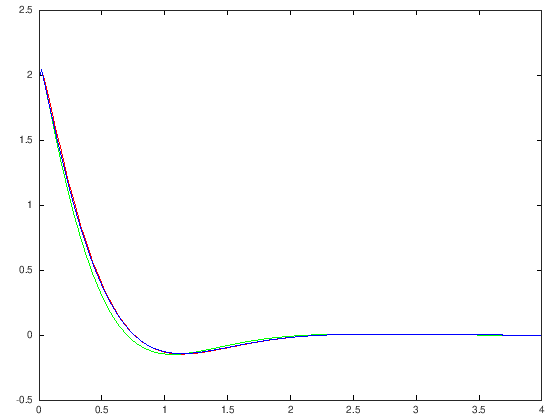

In [19]:
Ts2 = 0.05;

sc6.ChangeParameters(6,Ts2);

sc6.Reset();
out7 = sc6.Run([2 6]);
plot(out7(1,:),out7(2,:),'r',out7(1,:),out7(3,:),'g',out6(1,:),out6(4,:),'b');